In [28]:
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [8]:
#Load ảnh,gắn nhãn
IMG_SIZE = 128
DATASET_PATH = "dataset"

classes = os.listdir(DATASET_PATH)
print("Classes:", classes)

X = []
y = []

for label, class_name in enumerate(classes):
    class_path = os.path.join(DATASET_PATH, class_name)

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        X.append(img)
        y.append(label)

X = np.array(X)
y = np.array(y)

print("Shape X:", X.shape)
print("Shape y:", y.shape)

Classes: ['snow', 'rime', 'hail', 'sandstorm', 'frost', 'fogsmog', 'rain', 'lightning', 'dew', 'glaze', 'rainbow']
Shape X: (6862, 128, 128, 3)
Shape y: (6862,)


In [9]:
#Đếm ảnh
labels_count = []

for cls in classes:
    class_path = os.path.join(DATASET_PATH, cls)
    count = len(os.listdir(class_path))
    labels_count.append(count)

print(labels_count)

[621, 1160, 591, 692, 475, 851, 526, 377, 698, 639, 232]


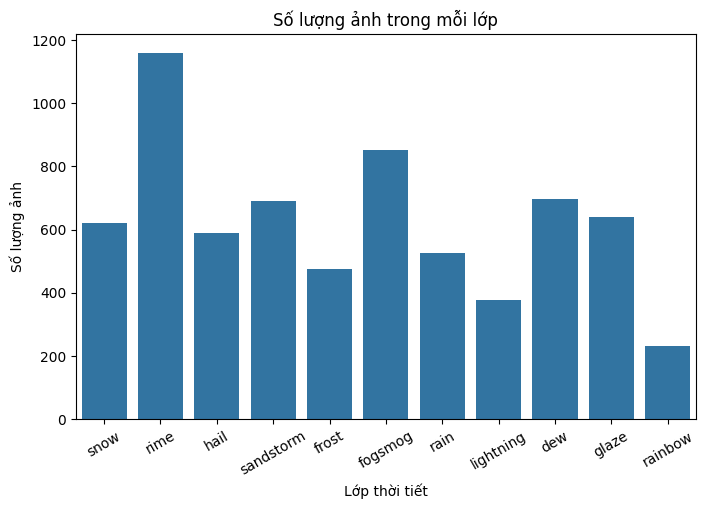

In [10]:
#Trực quan hóa dữ liệu
plt.figure(figsize=(8,5))
sns.barplot(x=classes, y=labels_count)
plt.title("Số lượng ảnh trong mỗi lớp")
plt.xlabel("Lớp thời tiết")
plt.ylabel("Số lượng ảnh")
plt.xticks(rotation=30)
plt.show()

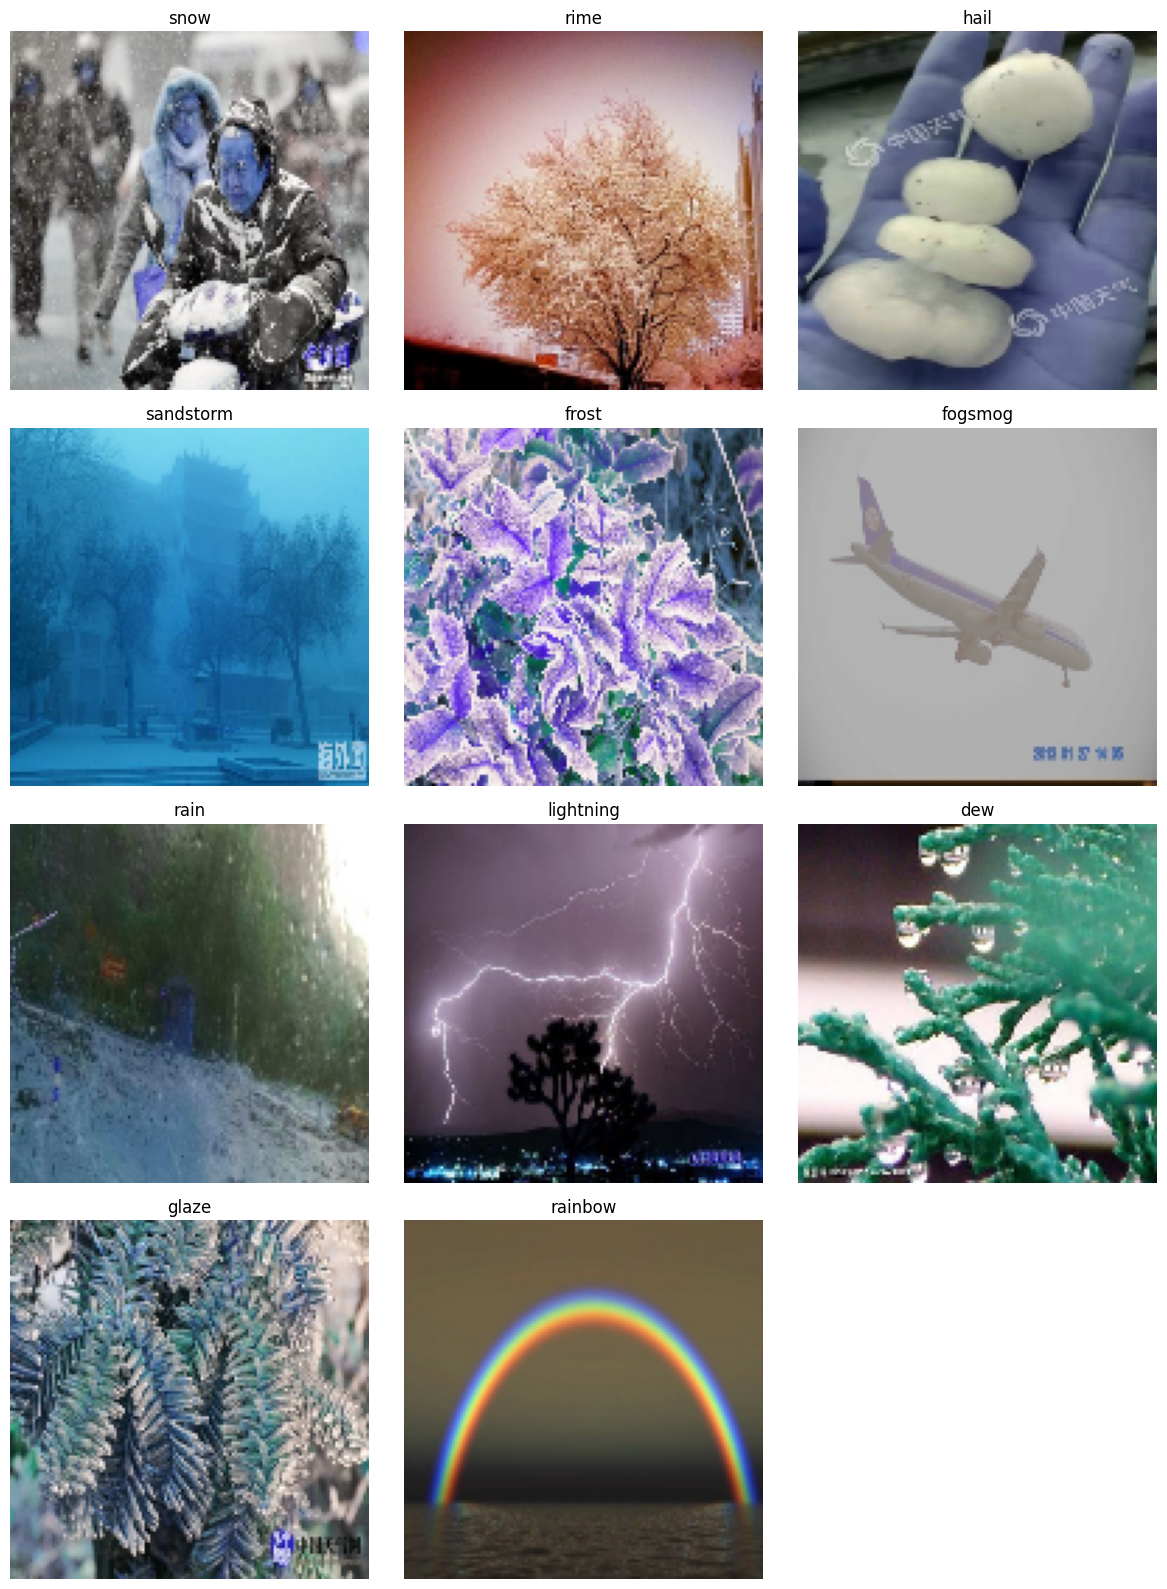

In [11]:
num_classes = len(classes)
cols = 3
rows = int(np.ceil(num_classes / cols))

plt.figure(figsize=(cols*4, rows*4))

for i, class_name in enumerate(classes):
    idx = np.where(y == i)[0][0]
    plt.subplot(rows, cols, i+1)
    plt.imshow(X[idx])
    plt.title(class_name)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [12]:
#Tiền xử lí
from tensorflow.keras.utils import to_categorical

# Chuẩn hóa pixel về [0,1]
X = X / 255.0

# One-hot encoding label
y = to_categorical(y, num_classes=len(classes))

In [13]:
#Lấy lại nhãn số
y = np.argmax(y, axis=1)

In [14]:
#Chia train/test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape)
print("Test:", X_test.shape)

Train: (5489, 128, 128, 3)
Test: (1373, 128, 128, 3)


In [15]:
#Build CNN
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(len(classes), activation='softmax')
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,955 (12.62 MB)

 Trainable params: 3,306,507 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [16]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 299s 2s/step - accuracy: 0.3302 - loss: 4.3958 - val_accuracy: 0.1828 - val_loss: 3.5007
Epoch 2/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - accuracy: 0.3659 - loss: 1.9633 - val_accuracy: 0.3052 - val_loss: 2.6484
Epoch 3/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.3957 - loss: 1.7286 - val_accuracy: 0.4115 - val_loss: 1.7700
Epoch 4/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - accuracy: 0.4191 - loss: 1.7093 - val_accuracy: 0.5484 - val_loss: 1.3780
Epoch 5/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - accuracy: 0.4432 - loss: 1.5598 - val_accuracy: 0.5229 - val_loss: 1.4494
Epoch 6/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.4494 - loss: 1.5253 - val_accuracy: 0.4399 - val_loss: 2.2059
Epoch 7/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.4645 - loss: 1.4868 - val_accuracy: 0.3365 - val_loss: 3.4288
Epoch 8/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accuracy: 0.5011 - loss: 1.3907 - val_accu

In [19]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 348ms/step - accuracy: 0.6450 - loss: 1.2006
Test accuracy: 0.6445739269256592


In [21]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = y_test

43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 318ms/step


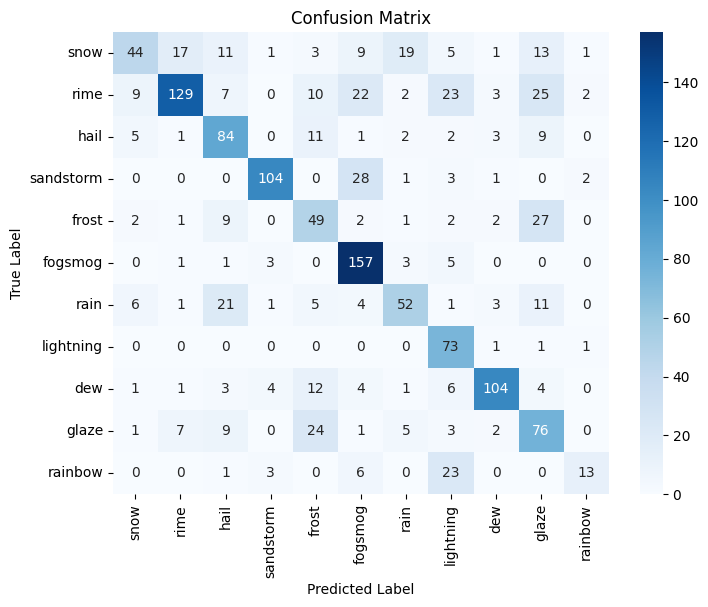

In [22]:
#Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Vẽ
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes,
            yticklabels=classes)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [25]:
#Precision,Recall,F1-score cho từng lớp
print(classification_report(
    y_true,
    y_pred_classes,
    target_names=classes
))

              precision    recall  f1-score   support

        snow       0.65      0.35      0.46       124
        rime       0.82      0.56      0.66       232
        hail       0.58      0.71      0.64       118
   sandstorm       0.90      0.75      0.82       139
       frost       0.43      0.52      0.47        95
     fogsmog       0.67      0.92      0.78       170
        rain       0.60      0.50      0.54       105
   lightning       0.50      0.96      0.66        76
         dew       0.87      0.74      0.80       140
       glaze       0.46      0.59      0.52       128
     rainbow       0.68      0.28      0.40        46

    accuracy                           0.64      1373
   macro avg       0.65      0.63      0.61      1373
weighted avg       0.68      0.64      0.64      1373



In [38]:
from google.colab import files
uploaded = files.upload()

Saving anima.png to anima.png


In [39]:
img_path = "anima.png"
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)

# Chuẩn hóa nếu model huấn luyện có normalize
img_array = img_array / 255.0

# Thêm batch dimension (bắt buộc cho predict)
img_array = np.expand_dims(img_array, axis=0)

# Dự đoán
prediction = model.predict(img_array)

# Xử lý kết quả
if prediction.shape[1] == 1:  # binary classification
    predicted_class = int(prediction[0][0] > 0.5)
else:  # multi-class
    predicted_class = np.argmax(prediction, axis=1)[0]

print("Dự đoán thời tiết:", classes[predicted_class])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Dự đoán thời tiết: frost
